In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels
from statsmodels.stats import power, gof
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='paper', ticks=True, grid=True)

# Simulated 2x2 contingency test

*Underlying effects:*
Effect prevalence (treatment) = P1 = 0.03
Effect prevalence (control) = P2 = 0.02

In [2]:
P1 = 0.3
P2 = 0.2
P = [P1,P2]
underlying = pd.DataFrame(np.array([[P1,1-P1],[P2,1-P2]]), index=['treatment','control'], columns=['effect','no effect'])
print('Prevalence: %.3f'%(underlying.iloc[:,0].sum()/underlying.sum().sum()))
TP = underlying.loc['treatment','effect']
FP = underlying.loc['treatment','no effect']
TN = underlying.loc['control','no effect']
FN = underlying.loc['control','effect']
oddsratio = (TP/FP)/(FN/TN)
print('Odds ratio: %.3f'%oddsratio)
display(underlying)
print('Underlying effect size: %.3f'%gof.chisquare_effectsize(
        underlying.loc['treatment'].values,
        underlying.loc['control'].values,
        cohen = True,
    ))
es_underlying = gof.chisquare_effectsize(
        underlying.loc['treatment'].values,
        underlying.loc['control'].values,
        cohen = True,
    )

Prevalence: 0.250
Odds ratio: 1.714


,effect,no effect
treatment,0.3,0.7
control,0.2,0.8


Underlying effect size: 0.218


In [3]:
# generate results for preliminary studies
studies = pd.DataFrame()
sample_sizes = np.random.randint(50,200,10)
for i in range(len(sample_sizes)):
    prelim = pd.DataFrame(index=['treatment','control'],
                      columns=pd.Index(['effect','no effect'],name='prelim'))
    prelim['effect'] = np.random.binomial(sample_sizes[i],P)
    prelim['no effect'] = sample_sizes[i] - prelim['effect']
    studies = studies.append(
        pd.Series({a:b for (a,b) in prelim.melt(ignore_index=False).apply(
            lambda x: (x.name +' '+x.prelim,x.value),
            result_type='reduce',
            axis=1
        ).values}),ignore_index=True)
    prelim_es = gof.chisquare_effectsize(
        prelim.loc['treatment'],
        prelim.loc['control'],
        cohen = True,
    )
    #prelim_pwr = gof.chisquare_power(prelim_es,n_prelim*2,2,alpha = stats.fisher_exact(prelim)[1])
    studies.loc[i,'effectsize'] = prelim_es
    #studies.loc[i,'power'] = prelim_pwr
    studies.loc[i,'oddsratio'], studies.loc[i,'pvalue'] = stats.fisher_exact(prelim)
studies.index.name = 'study#'
studies = studies.convert_dtypes()
studies = studies[studies.pvalue < 0.1] # publication bias
studies

,control effect,control no effect,treatment effect,treatment no effect,effectsize,oddsratio,pvalue
study#,,,,,,,
0,31,138,46,123,0.199416,1.664831,0.069008
1,26,138,49,115,0.306394,2.261538,0.003645
2,30,154,49,135,0.233609,1.863210,0.021920
3,25,107,39,93,0.232463,1.794839,0.061404
6,26,118,40,104,0.217061,1.745562,0.067871
7,28,89,43,74,0.265914,1.847008,0.046110
9,40,153,58,135,0.203419,1.643333,0.046483


In [4]:
studies['variance_ES'] = pd.Series(sample_sizes)*2 / pd.Series(sample_sizes)**2 \
                            + studies.effectsize**2 / pd.Series(sample_sizes)*2
studies['95% CI'] = studies.apply(lambda x:"(%.2f, %.2f)"%(
    x.effectsize - 1.96*np.sqrt(x.variance_ES), x.effectsize + 1.96*np.sqrt(x.variance_ES)),axis=1)
studies[['variance_ES','effectsize','95% CI']]

,variance_ES,effectsize,95% CI
study#,,,
0,0.012305,0.199416,"(-0.02, 0.42)"
1,0.013340,0.306394,"(0.08, 0.53)"
2,0.011463,0.233609,"(0.02, 0.44)"
3,0.015970,0.232463,"(-0.02, 0.48)"
6,0.014543,0.217061,"(-0.02, 0.45)"
7,0.018303,0.265914,"(0.00, 0.53)"
9,0.010791,0.203419,"(-0.00, 0.41)"


In [5]:
pooled_ES = (studies.effectsize / studies.variance_ES).sum() / (1/studies.variance_ES).sum()
pooled_ES_SE = np.sqrt(1/(1/studies.variance_ES).sum())
pooled_ES_CI = (pooled_ES - 1.96*pooled_ES_SE, pooled_ES + 1.96*pooled_ES_SE)
print("Pooled Effect Size and 95%% CI: %.3f, (%.2f,%.2f)"%(pooled_ES, *pooled_ES_CI))

Pooled Effect Size and 95% CI: 0.234, (0.15,0.32)


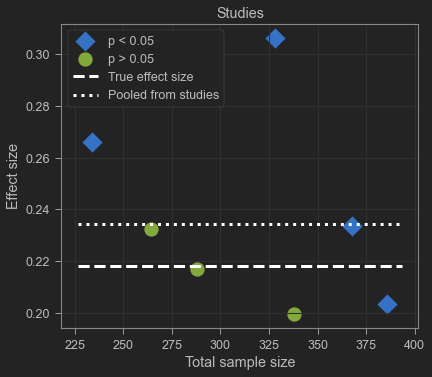

In [6]:
plt.scatter(
    studies[studies.pvalue < 0.05].iloc[:,:4].sum(axis=1),
    studies.effectsize[studies.pvalue < 0.05],
    label = 'p < 0.05',
    marker = 'D',
    s = 200
)
plt.scatter(
    studies[studies.pvalue > 0.05].iloc[:,:4].sum(axis=1),
    studies.effectsize[studies.pvalue > 0.05],
    label = 'p > 0.05',
    marker = 'o',
    s = 200
)
plt.ylabel('Effect size')
plt.xlabel('Total sample size')
xmin,xmax = plt.xlim()
plt.hlines(es_underlying,color='w',xmin=xmin,xmax=xmax,linewidth=3,linestyles = 'dashed',label='True effect size')
plt.hlines(
    pooled_ES,color='w',xmin=xmin,xmax=xmax,linewidth=3,linestyles = 'dotted',label='Pooled from studies')
plt.legend()
plt.title('Studies');

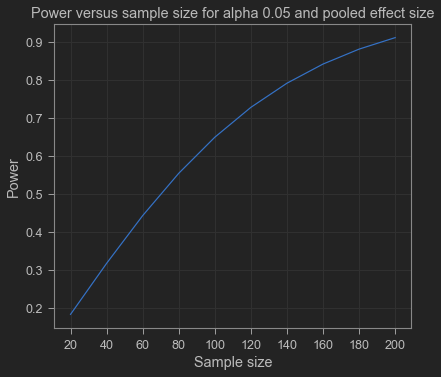

In [7]:
samplesizes = np.arange(20,201,20)
powers = list(map(lambda n: gof.chisquare_power(pooled_ES,n,2,alpha=0.05),samplesizes))
plt.plot(samplesizes,powers)
plt.xticks(samplesizes)
plt.xlabel('Sample size')
plt.title('Power versus sample size for alpha 0.05 and pooled effect size')
plt.ylabel('Power');

In [8]:
n = 2
while gof.chisquare_power(pooled_ES,n,2,alpha=0.05) < 0.90:
    n += 2
print('Required total samples for 90%% power to detect %.3f effect size at alpha = 0.05:\n%d'%(pooled_ES,n))

Required total samples for 90% power to detect 0.234 effect size at alpha = 0.05:
192


In [9]:
pvals = []
effects = []
powers = []
for i in range(50):
    # see what result we get
    study = pd.DataFrame(index=['treatment','control'],
                      columns=pd.Index(['effect','no effect'],name='study'))
    study['effect'] = np.random.binomial(n//2,P)
    study['no effect'] = n//2 - study['effect']
    es = gof.chisquare_effectsize(
        study.loc['treatment'],
        study.loc['control'],
        cohen = True,)
    p = stats.fisher_exact(study)[1]
    pwr = gof.chisquare_power(
        es,study.sum().sum(),2,stats.fisher_exact(study)[1])
    pvals.append(p)
    powers.append(pwr)
    effects.append(es)
pvals = np.array(pvals)
effects = np.array(effects)
powers = np.array(powers)

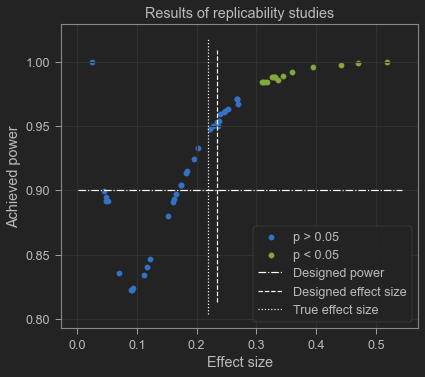

In [10]:
plt.scatter(effects[pvals>0.05],powers[pvals>0.05], label = 'p > 0.05')
plt.scatter(effects[pvals<0.05],powers[pvals<0.05], label = 'p < 0.05')
plt.xlabel('Effect size')
plt.ylabel('Achieved power')
plt.hlines(0.90,*plt.xlim(), color = 'w', label='Designed power', linestyles='dashdot')
plt.vlines(pooled_ES,*plt.ylim(), color = 'w', label='Designed effect size', linestyles='dashed')
plt.vlines(es_underlying,*plt.ylim(), color = 'w', label='True effect size', linestyles = 'dotted')
plt.title('Results of replicability studies')
plt.legend();

In [11]:
print('Proportion of studies that found a significant \nresult for the given study size:')
print('%.1f %%'%((pvals<0.05).mean()*100))

Proportion of studies that found a significant 
result for the given study size:
30.0 %


In [12]:
# Alternative method
conf = 0.90 # as a fraction e.g. 0.95 is 95% CI
print('Pooled Effect Size: %.3f'%pooled_ES)
cilb = pooled_ES - pooled_ES_SE*stats.norm.ppf(1-(1-conf)/2)
ciub = pooled_ES + pooled_ES_SE*stats.norm.ppf(1-(1-conf)/2)
print('%d %% CI: (%.3f, %.3f)'%(np.round(conf*100),cilb,ciub))
CILB = conf + (1-conf)/2
print('%d %% one sided confidence interval: (%.3f, %s)'%(CILB*100,cilb,'infinity'))

Pooled Effect Size: 0.234
90 % CI: (0.162, 0.306)
95 % one sided confidence interval: (0.162, infinity)


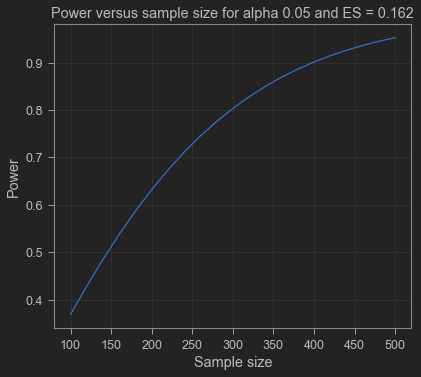

In [13]:
samplesizes = np.arange(100,501,20)
powers = list(map(lambda n: gof.chisquare_power(cilb,n,2,alpha=0.05),samplesizes))
plt.plot(samplesizes,powers)
#plt.xticks(samplesizes)
plt.xlabel('Sample size')
plt.title('Power versus sample size for alpha 0.05 and ES = %.3f'%cilb)
plt.ylabel('Power');

In [14]:
n = 2
while gof.chisquare_power(cilb,n,2,alpha=0.05) < 0.90:
    n += 2
print('Required total samples for 90%% power to detect %.3f effect size at alpha = 0.05:\n%d'%(cilb,n))

Required total samples for 90% power to detect 0.162 effect size at alpha = 0.05:
400


In [15]:
pvals = []
effects = []
powers = []
for i in range(50):
    # see what result we get
    study = pd.DataFrame(index=['treatment','control'],
                      columns=pd.Index(['effect','no effect'],name='study'))
    study['effect'] = np.random.binomial(n//2,P)
    study['no effect'] = n//2 - study['effect']
    es = gof.chisquare_effectsize(
        study.loc['treatment'],
        study.loc['control'],
        cohen = True,)
    p = stats.fisher_exact(study)[1]
    pwr = gof.chisquare_power(
        es,study.sum().sum(),2,stats.fisher_exact(study)[1])
    pvals.append(p)
    powers.append(pwr)
    effects.append(es)
pvals = np.array(pvals)
effects = np.array(effects)
powers = np.array(powers)

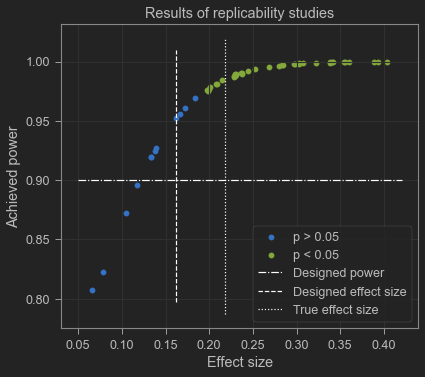

In [16]:
plt.scatter(effects[pvals>0.05],powers[pvals>0.05], label = 'p > 0.05')
plt.scatter(effects[pvals<0.05],powers[pvals<0.05], label = 'p < 0.05')
plt.xlabel('Effect size')
plt.ylabel('Achieved power')
plt.hlines(0.90,*plt.xlim(), color = 'w', label='Designed power', linestyles='dashdot')
plt.vlines(cilb,*plt.ylim(), color = 'w', label='Designed effect size', linestyles='dashed')
plt.vlines(es_underlying,*plt.ylim(), color = 'w', label='True effect size', linestyles = 'dotted')
plt.title('Results of replicability studies')
plt.legend();

In [17]:
print('Proportion of studies that found a significant \nresult for the given study size:')
print('%.1f %%'%((pvals<0.05).mean()*100))

Proportion of studies that found a significant 
result for the given study size:
76.0 %


# Simulated independent t test
Param is 15% greater under treatment than under control

Population Effect Size: 0.429


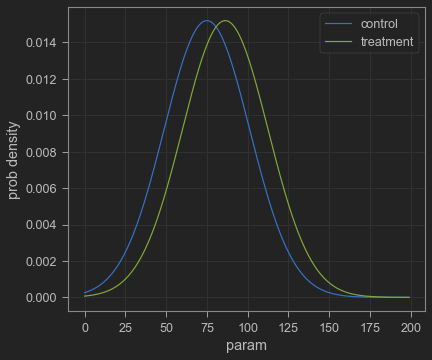

In [61]:
pop_mean_control = 75
pop_mean_treatment = pop_mean_control * 1.15
pop_std = 0.35*pop_mean_control
x = np.arange(0,200)
plt.plot(x,stats.norm.pdf(x, loc=pop_mean_control, scale=pop_std),label='control')
plt.plot(x,stats.norm.pdf(x, loc=pop_mean_treatment, scale=pop_std),label='treatment')
plt.legend();
plt.xlabel('param')
plt.ylabel('prob density');
pop_effect_size = (pop_mean_treatment-pop_mean_control)/pop_std
print('Population Effect Size: %.3f'%pop_effect_size)

In [62]:
from statsmodels.stats.weightstats import ttest_ind

In [63]:
def sd_cohen_d(n1,n2,d):
    return np.sqrt((n1+n2)/(n1*n2) + (d**2)/(2*(n1+n2)))
def pooled_sd(sigmas,sizes):
    assert(len(sigmas)==len(sizes))
    numerator = sum([(n-1)*s**2 for (n,s) in zip(sizes,sigmas)])
    denominator = sum([n]+[-len(sizes)])
    return np.sqrt(numerator/denominator)

In [64]:
pd.set_option("precision", 3)

In [65]:
# generate results for preliminary studies
studies = pd.DataFrame()
sample_sizes = np.random.randint(10,50,10)
for i in sample_sizes:
    cntrl = np.random.normal(loc=pop_mean_control, scale=pop_std,size=i)
    trtmnt = np.random.normal(loc=pop_mean_treatment, scale=pop_std,size=i)
    t,p, _ = ttest_ind(cntrl,trtmnt,'two-sided')
    studies = studies.append(
        pd.DataFrame(
            np.array([cntrl.mean(), cntrl.std(), trtmnt.mean(), trtmnt.std(),i,i,p,t]).reshape(1,-1),
            columns=['mu_control','sd_control','mu_treatment',
                     'sd_treatment','n_control','n_treatment',
                     'ttest_ind_p','t_statistic']
        ), ignore_index=True)
studies.index.name = 'study#'
studies = studies.convert_dtypes()
#studies = studies[studies['ttest_ind_p'] < 0.1] # publication bias
studies['pooled_sd'] = studies.apply(lambda x: pooled_sd([x.sd_control,x.sd_treatment],
                                                        [x.n_control, x.n_treatment]),axis=1)
studies['ES'] = (studies.mu_treatment - studies.mu_control)/studies.pooled_sd
studies['sd_ES'] = studies.apply(lambda x: sd_cohen_d(x.n_control, x.n_treatment, x.ES),axis=1)
studies['95% CI on ES'] = studies.apply(lambda x: "(%.3f, %.3f)"%(
    x.ES-1.96*x.sd_ES,
    x.ES+1.96*x.sd_ES
),axis=1)
studies.T

study#,0,1,2,3,4,5,6,7,8,9
mu_control,79.1,76.1,79.1,75.2,79.9,66.4,71.3,68.9,66,77.9
sd_control,15.2,27.6,30.2,22.9,24.9,21.1,32.2,26.2,26.9,27.4
mu_treatment,83.8,89,102,90.7,90.9,89.4,82.7,92.3,89.3,79.3
sd_treatment,25.5,28.9,29.8,24.7,25.6,21.2,22.1,23.2,30.1,28.6
n_control,21,47,12,46,48,15,11,34,45,44
n_treatment,21,47,12,46,48,15,11,34,45,44
ttest_ind_p,0.479,0.0309,0.0812,0.00263,0.036,0.00766,0.365,0.000276,0.000244,0.826
t_statistic,-0.715,-2.19,-1.83,-3.09,-2.13,-2.87,-0.928,-3.84,-3.82,-0.22
pooled_sd,26,53.2,27.6,44.3,48,21.9,24.2,39.4,52.5,50.9
ES,0.182,0.243,0.847,0.351,0.231,1.05,0.473,0.594,0.443,0.0261


In [66]:
pooled_ES = (studies.ES / studies.sd_ES**2).sum() / (1/studies.sd_ES**2).sum()
pooled_ES_SE = np.sqrt(1/(1/studies.sd_ES**2).sum())
pooled_ES_CI = (pooled_ES - 1.96*pooled_ES_SE, pooled_ES + 1.96*pooled_ES_SE)
print("Pooled Effect Size and 95%% CI: %.3f, (%.2f,%.2f)"%(pooled_ES, *pooled_ES_CI))

Pooled Effect Size and 95% CI: 0.349, (0.19,0.50)


In [67]:
n = 5
ratio = 1
while power.TTestIndPower().power(pooled_ES,n,alpha=0.05,ratio = ratio) < 0.90:
    n += 1
print('Required samples for 90%% power to detect %.3f effect size at alpha = 0.05:\n%d + %d'%(pooled_ES,n,ratio*n))

Required samples for 90% power to detect 0.349 effect size at alpha = 0.05:
174 + 174


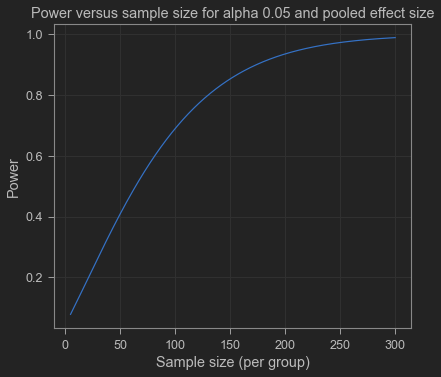

In [70]:
samplesizes = np.arange(5,301,1)
powers = list(map(lambda n: power.TTestIndPower().power(pooled_ES,n,alpha=0.05,ratio=ratio),samplesizes))
plt.plot(samplesizes,powers)
plt.xlabel('Sample size (per group)')
plt.title('Power versus sample size for alpha 0.05 and pooled effect size')
plt.ylabel('Power');

In [71]:
pvals = []
effects = []
powers = []
for i in range(50):
    # see what result we get
    cntrl = np.random.normal(loc=pop_mean_control, scale=pop_std,size=n)
    trtmnt = np.random.normal(loc=pop_mean_treatment, scale=pop_std,size=n*ratio)
    t,p, _ = ttest_ind(cntrl,trtmnt,'two-sided')
    study = pd.DataFrame(
        np.array([cntrl.mean(), cntrl.std(), trtmnt.mean(), trtmnt.std(),n,n*ratio,p,t]).reshape(1,-1),
        columns=['mu_control','sd_control','mu_treatment',
            'sd_treatment','n_control','n_treatment',
            'ttest_ind_p','t_statistic']
    )
    study['pooled_sd'] = study.apply(lambda x: pooled_sd([x.sd_control,x.sd_treatment],
                                                        [x.n_control, x.n_treatment]),axis=1)
    es = (study.mu_treatment - study.mu_control)/study.pooled_sd
    pwr = power.TTestIndPower().power(es,n,alpha=0.05,ratio=ratio)
    pvals.append(p)
    powers.append(pwr)
    effects.append(es)
pvals = np.array(pvals)
effects = np.array(effects)
powers = np.array(powers)

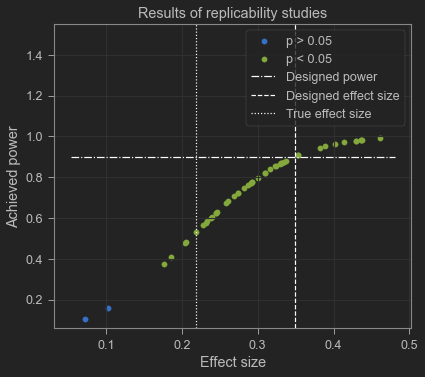

In [72]:
plt.scatter(effects[pvals>0.05],powers[pvals>0.05], label = 'p > 0.05')
plt.scatter(effects[pvals<0.05],powers[pvals<0.05], label = 'p < 0.05')
plt.ylim(plt.ylim()[0],plt.ylim()[1]*1.5)
plt.xlabel('Effect size')
plt.ylabel('Achieved power')
plt.hlines(0.90,*plt.xlim(), color = 'w', label='Designed power', linestyles='dashdot')
plt.vlines(pooled_ES,*plt.ylim(), color = 'w', label='Designed effect size', linestyles='dashed')
plt.vlines(es_underlying,*plt.ylim(), color = 'w', label='True effect size', linestyles = 'dotted')
plt.title('Results of replicability studies')
plt.legend();

In [73]:
# Alternative method
conf = 0.90 # as a fraction e.g. 0.95 is 95% CI
print('Pooled Effect Size: %.3f'%pooled_ES)
cilb = pooled_ES - pooled_ES_SE*stats.norm.ppf(1-(1-conf)/2)
ciub = pooled_ES + pooled_ES_SE*stats.norm.ppf(1-(1-conf)/2)
print('%d %% CI: (%.3f, %.3f)'%(np.round(conf*100),cilb,ciub))
CILB = conf + (1-conf)/2
print('%d %% one sided confidence interval: (%.3f, %s)'%(CILB*100,cilb,'infinity'))

Pooled Effect Size: 0.349
90 % CI: (0.218, 0.480)
95 % one sided confidence interval: (0.218, infinity)


In [74]:
n = 5
ratio = 1
while power.TTestIndPower().power(cilb,n,alpha=0.05,ratio = ratio) < 0.90:
    n += 1
print('Required samples for 90%% power to detect %.3f effect size at alpha = 0.05:\n%d + %d'%(pooled_ES,n,ratio*n))

Required samples for 90% power to detect 0.349 effect size at alpha = 0.05:
444 + 444


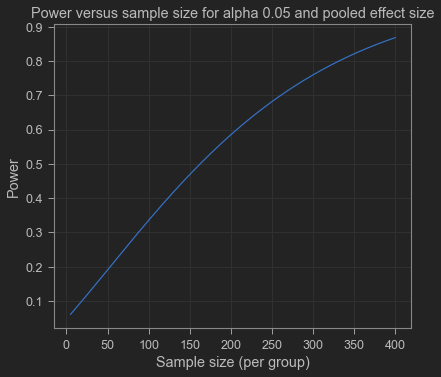

In [76]:
samplesizes = np.arange(5,401,1)
powers = list(map(lambda n: power.TTestIndPower().power(cilb,n,alpha=0.05,ratio=ratio),samplesizes))
plt.plot(samplesizes,powers)
plt.xlabel('Sample size (per group)')
plt.title('Power versus sample size for alpha 0.05 and pooled effect size')
plt.ylabel('Power');

In [77]:
pvals = []
effects = []
powers = []
for i in range(50):
    # see what result we get
    cntrl = np.random.normal(loc=pop_mean_control, scale=pop_std,size=n)
    trtmnt = np.random.normal(loc=pop_mean_treatment, scale=pop_std,size=n*ratio)
    t,p, _ = ttest_ind(cntrl,trtmnt,'two-sided')
    study = pd.DataFrame(
        np.array([cntrl.mean(), cntrl.std(), trtmnt.mean(), trtmnt.std(),n,n*ratio,p,t]).reshape(1,-1),
        columns=['mu_control','sd_control','mu_treatment',
            'sd_treatment','n_control','n_treatment',
            'ttest_ind_p','t_statistic']
    )
    study['pooled_sd'] = study.apply(lambda x: pooled_sd([x.sd_control,x.sd_treatment],
                                                        [x.n_control, x.n_treatment]),axis=1)
    es = (study.mu_treatment - study.mu_control)/study.pooled_sd
    pwr = power.TTestIndPower().power(es,n,alpha=0.05,ratio=ratio)
    pvals.append(p)
    powers.append(pwr)
    effects.append(es)
pvals = np.array(pvals)
effects = np.array(effects)
powers = np.array(powers)

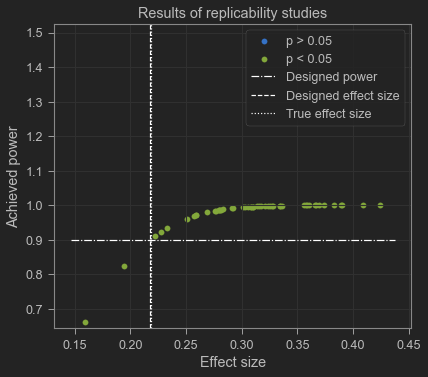

In [78]:
plt.scatter(effects[pvals>0.05],powers[pvals>0.05], label = 'p > 0.05')
plt.scatter(effects[pvals<0.05],powers[pvals<0.05], label = 'p < 0.05')
plt.ylim(plt.ylim()[0],plt.ylim()[1]*1.5)
plt.xlabel('Effect size')
plt.ylabel('Achieved power')
plt.hlines(0.90,*plt.xlim(), color = 'w', label='Designed power', linestyles='dashdot')
plt.vlines(cilb,*plt.ylim(), color = 'w', label='Designed effect size', linestyles='dashed')
plt.vlines(es_underlying,*plt.ylim(), color = 'w', label='True effect size', linestyles = 'dotted')
plt.title('Results of replicability studies')
plt.legend();